Hello! We are going to use a chunk of Sloan Digital Sky Survey's data here. Our aim is to build some machine learning model to classify galaxies/stars/quasars based on their spectral properties. After that we will also consider differnt metrics to assess those models' performance.

First thing first. Let's import some mandatory modules and packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import seaborn as sns
style.use(style='seaborn-deep')
from tabulate import tabulate
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

Accessing the dataset..............

In [2]:
sdss_df = pd.read_csv('star_classification.csv')

Let's check some basic info about the dataset.

In [3]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

So, there are 100,000 entries or rows and 18 columns in total.

In [4]:
print("The shape of the dataset: {}".format(sdss_df.shape))

The shape of the dataset: (100000, 18)


In [5]:
classes = sdss_df['class'].unique()
print(classes)

['GALAXY' 'QSO' 'STAR']


In [6]:
sdss_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.240000e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.540000e+18,GALAXY,0.634794,5812,56354,171
1,1.240000e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.180000e+19,GALAXY,0.779136,10445,58158,427
2,1.240000e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.150000e+18,GALAXY,0.644195,4576,55592,299
3,1.240000e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030000e+19,GALAXY,0.932346,9149,58039,775
4,1.240000e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.890000e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.240000e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,1.240000e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.590000e+18,GALAXY,0.404895,7626,56934,866
99997,1.240000e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.110000e+18,GALAXY,0.143366,2764,54535,74
99998,1.240000e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.600000e+18,GALAXY,0.455040,6751,56368,470


Let's check if there is any null value.

In [7]:
sdss_df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


All okay! No null value. Amazing!


In [8]:
sdss_df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

So, in our dataset there are 59445 galaxies, 21594 star, and 18961 QSOs. Now we can plot the Histogramof the classes. Here it is......

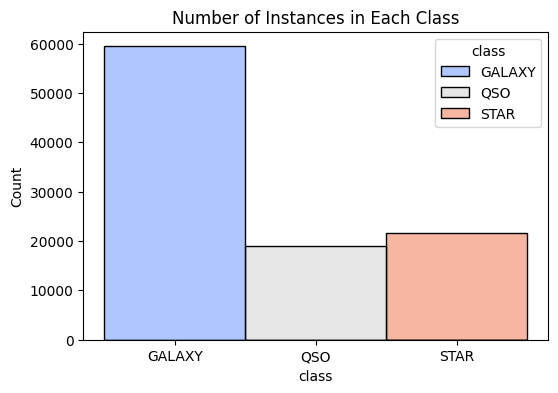

In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(data=sdss_df, x='class', hue='class', alpha=.7, palette='coolwarm')
plt.title('Number of Instances in Each Class')
plt.show()

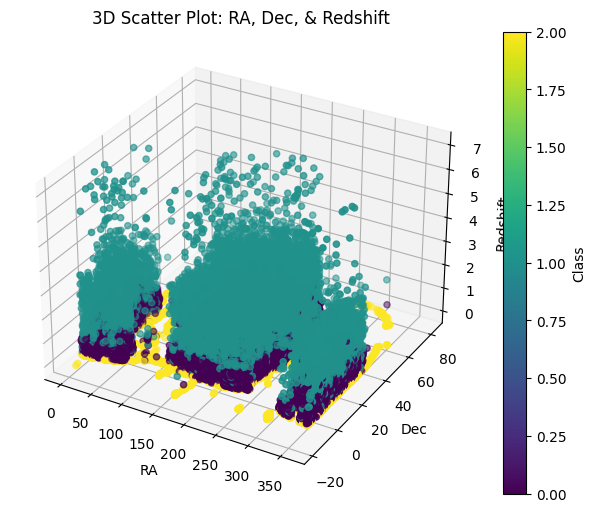

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
sdss_df['class_rep'] = le.fit_transform(sdss_df['class'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sdss_df['alpha'], sdss_df['delta'], sdss_df['redshift'], c=sdss_df['class_rep'], cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_zlabel('Redshift')
ax.set_title('3D Scatter Plot: RA, Dec, & Redshift')

# Adding color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Class')

plt.show()


In [11]:
sdss_all_var=sdss_df.drop(['class_rep','class'], axis=1)

Now, we will check the features' correlations.

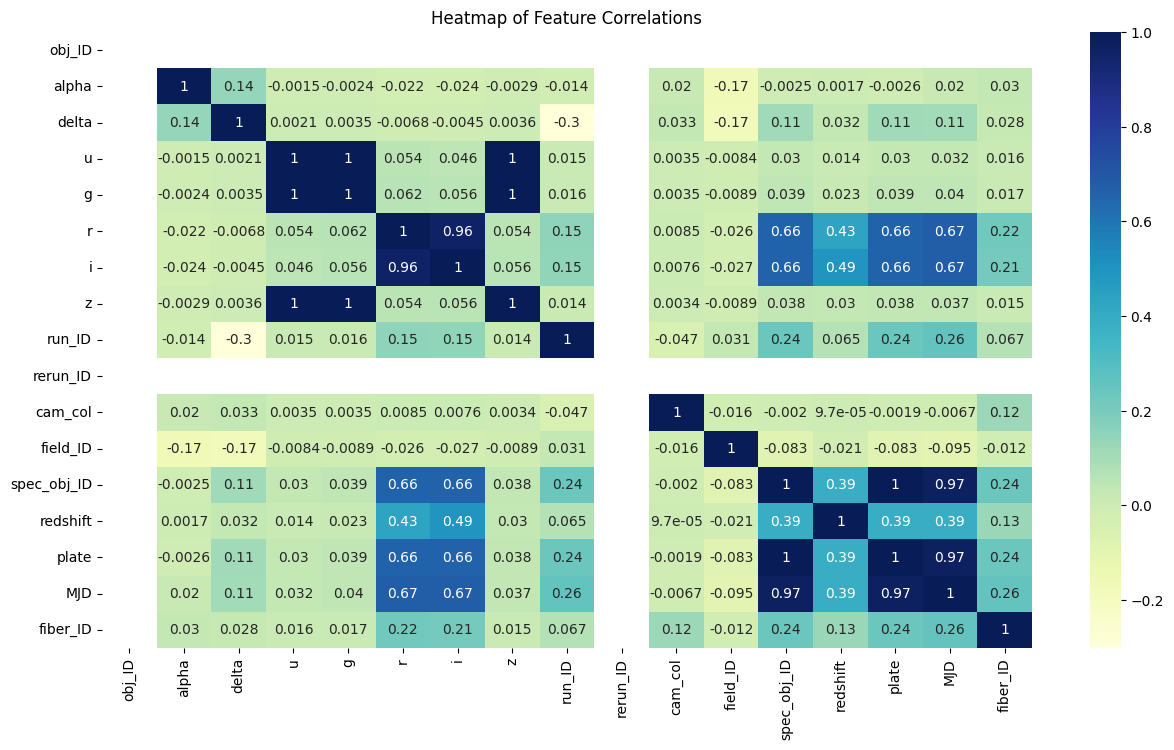

In [12]:
plt.figure(figsize=(15, 8))
sns.heatmap(sdss_all_var.corr(), annot=True, cmap="YlGnBu")
plt.title('Heatmap of Feature Correlations')
# Define the path to save the plot as a PNG file
save_path = r'C:\Users\DELL\Downloads\ml_paper\heatmap.png'

# Save the plot as a PNG file
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

At this point, we exclude columns that solely represent distinct identification numbers. Additionally, we remove MJD since it serves as a time indicator, and cam_col, which is unrelated to class distinctions. From our domain knowledge we know that alpha and delta have also should not have any effect on the classification. 

In [13]:
sdss_imp=sdss_df.drop(['alpha', 'delta','obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID', 'class_rep'], axis=1)
imp_columns = [ 'u', 'g', 'r', 'i', 'z', 'redshift']

In [14]:
sdss_imp

,u,g,r,i,z,class,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
99996,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
99997,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366
99998,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040


Let's visulaize the new column reduced dataset. 

In [15]:
def plot_boxplots(data_frame, analysis_columns, target_column):
    """
    This function generates boxplots for analyzing the distribution of data.

    Params:
    `data_frame`: DataFrame containing the dataset.
    `analysis_columns`: List of columns to analyze.
    `target_column`: Name of the target column.

    Returns:
    None
    """
    # Create a figure with appropriate size
    plt.figure(figsize=(15, 30))

    # Calculate the number of columns for subplots
    num_columns = len(analysis_columns)

    # Loop through the analysis columns
    for i, column in enumerate(analysis_columns):
        # Create a subplot for each feature
        plt.subplot(int('{}2{}'.format(num_columns, i+1)))

        # Generate a boxplot for the current feature
        sns.boxplot(x=target_column, y=column, data=data_frame, width=0.5, flierprops={'marker': 'x'})

        # Set the title for the boxplot
        plt.title(label='Boxplot of {}'.format(column), fontsize=10)

        # Remove x and y labels to avoid clutter
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)

    # Display the boxplots
    plt.show()

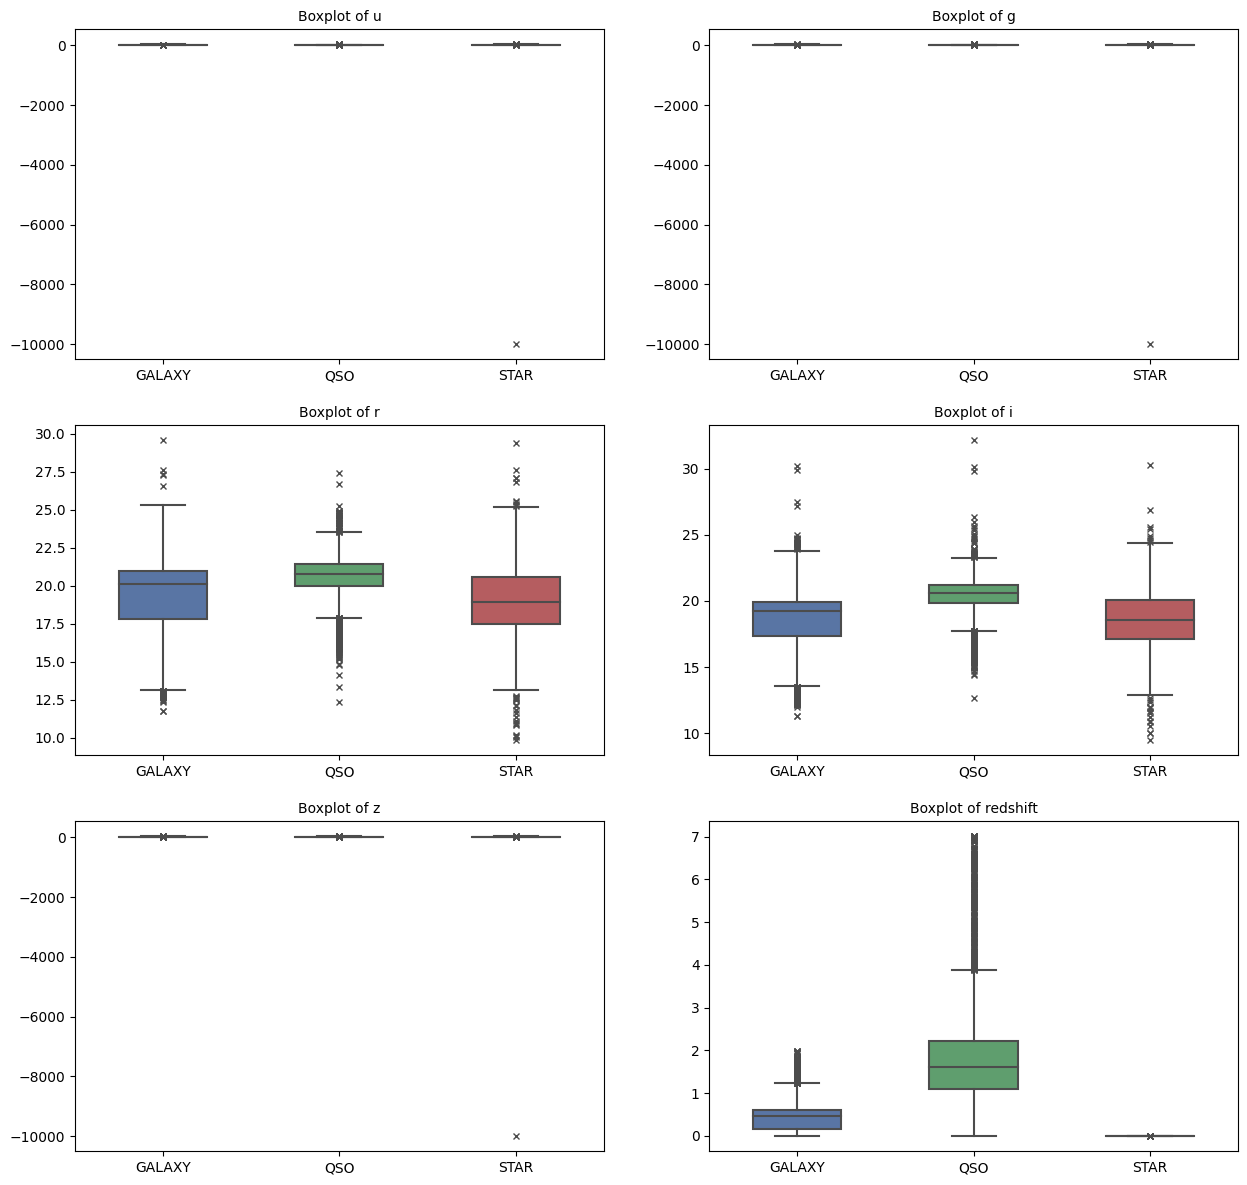

In [16]:
plot_boxplots(data_frame=sdss_imp, analysis_columns=imp_columns, target_column='class')

We can see that in case of the 'u', 'g', 'z' boxplots there are negative values. These values are obviously some kind of errors or outliers.  We have to get rid of these negative values as part of feature engineering.

In [17]:
display(sdss_imp[sdss_imp['u'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [18]:
display(sdss_imp[sdss_imp['g'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [19]:
display(sdss_imp[sdss_imp['z'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In all the cases only the 70543 no. row contain negative values. Let's remove it. 

In [20]:
sdss_imp = sdss_imp.drop(index=[79543])

In [21]:
print("New shape: {}".format(sdss_imp.shape))

New shape: (99999, 7)


We will boxplot again

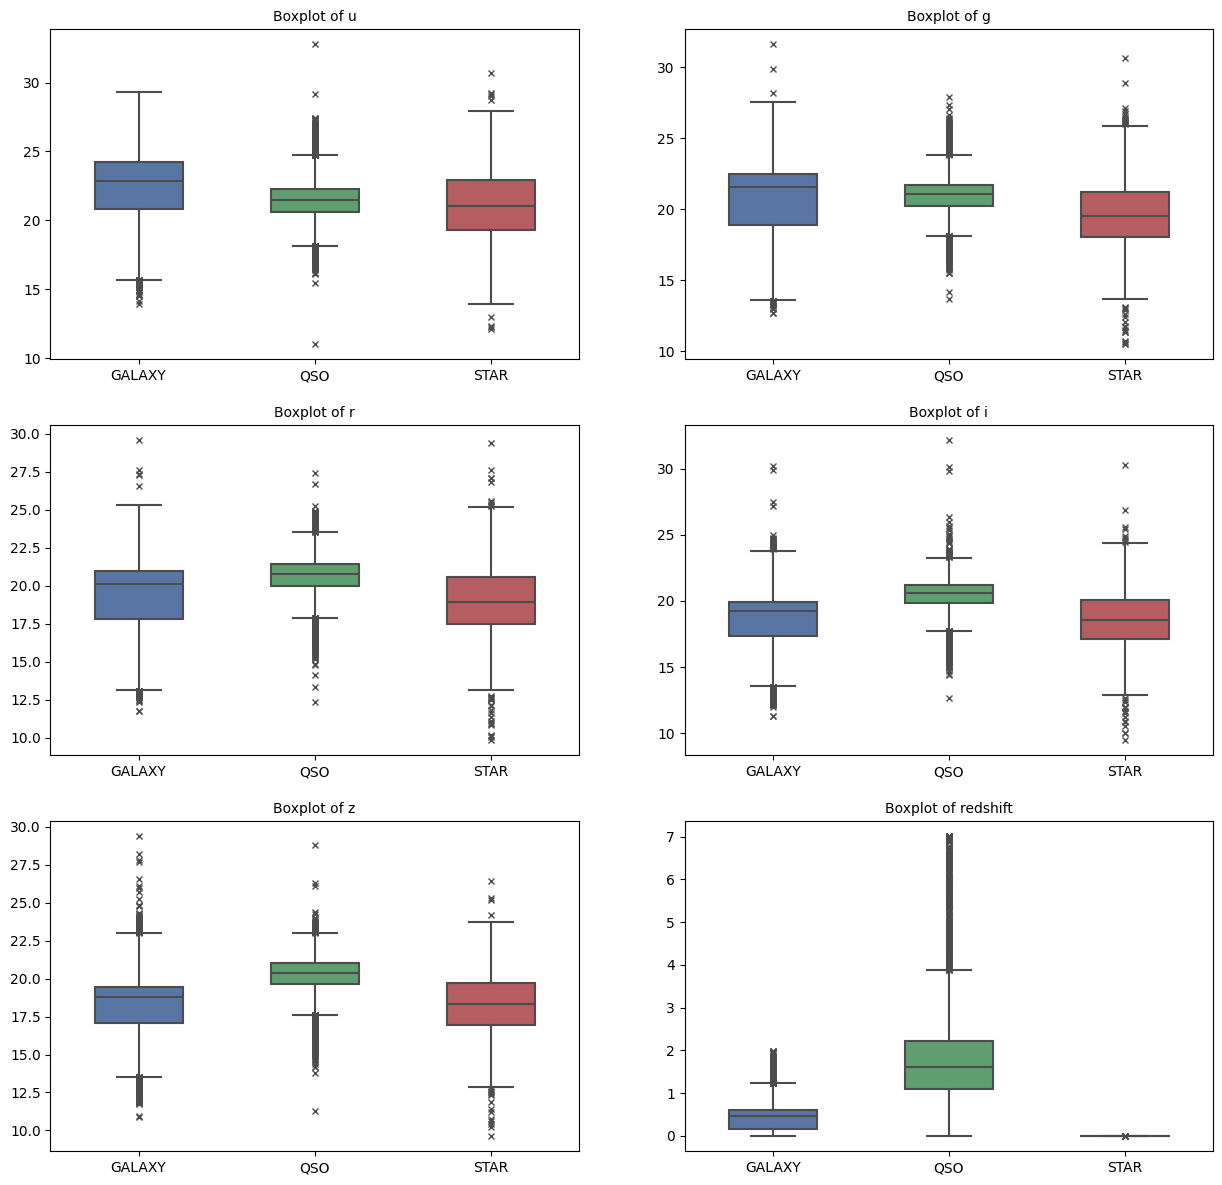

In [22]:
plot_boxplots(data_frame=sdss_imp, analysis_columns=imp_columns, target_column='class')

Now the boxplots are looking much better!!

Now, we will check the correlations of the important features' with each other.

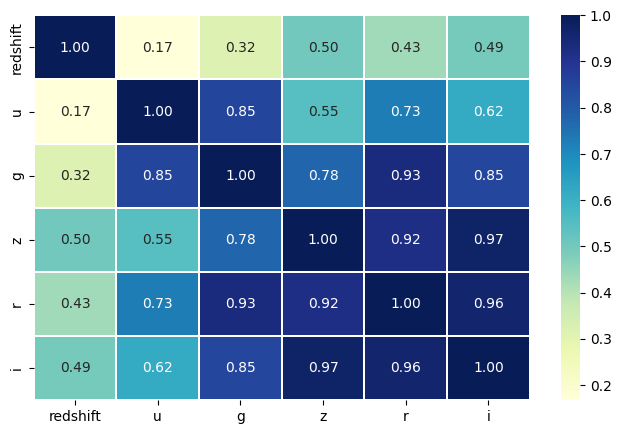

In [23]:
plt.figure(figsize=(8, 5))
sns.heatmap(data=sdss_imp[[ 'redshift','u', 'g', 'z', 'r', 'i']].corr(),
            annot=True, fmt='.2f', linewidths=0.1, cmap="YlGnBu")
plt.show()

Before excluding the row '79543' there were some correlations value equal to 1. But after eliminating that row, the new heatmap has no correlation value equal to 1.

In [24]:
X = sdss_imp[imp_columns]
y = sdss_imp['class'].values
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (99999, 6)
y shape: (99999,)


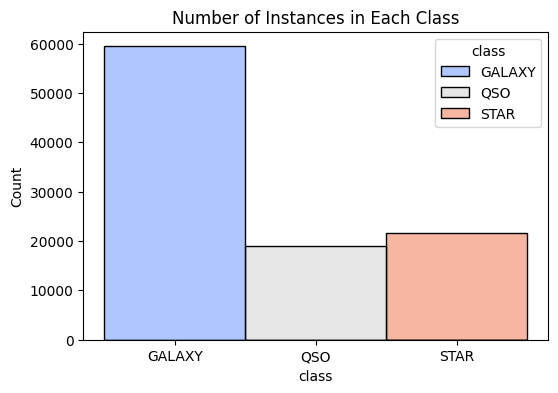

In [25]:
plt.figure(figsize=(6, 4))
sns.histplot(data=sdss_imp, x='class', hue='class', alpha=.7, palette='coolwarm')
plt.title('Number of Instances in Each Class')
plt.show()

From this histogram we can see that the three different classes in the dataset are very imbalanced. The amount of QSOs and stars are somewhat comparable, but the number of galaxies are almost 3 times than any other classification type. 

This is a very big issue. This phenomenon can create biases towards galaxy classification in our model. So, we need to treat this problem very carefully. To rescue ourselves there is a package called SMOTE function. This function is employed to address the issue of imbalanced datasets by creating artificial instances (dummy instances) of the minority class through interpolation based on existing minority class data points. 

In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [27]:
from collections import Counter
print(Counter(y))

Counter({'GALAXY': 59445, 'QSO': 59445, 'STAR': 59445})


We standardized our dataset using the StandardScaler module provided by the scikit-learn library.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
stdscal = StandardScaler()
X = stdscal.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(X)
print(y)
sdss_imp['class'] = le.fit_transform(sdss_imp['class'])

['GALAXY' 'QSO' 'STAR']
[[ 0.9787894   0.91976676  0.37028242 -0.06163149 -0.12370325 -0.08587325]
 [ 1.39479162  1.20552305  1.57026624  1.0672832   1.44833554  0.07218198]
 [ 1.61949956  1.11927454  0.4879827   0.04145071 -0.03755926 -0.07557925]
 ...
 [-1.30056964 -1.7926897  -2.10111253 -2.20925649 -2.23187216 -0.78178907]
 [ 0.18374298  0.00292935  0.20631057  0.36939554  0.4893328  -0.78067578]
 [-0.12261271 -0.71847042 -1.16370433 -1.75148474 -2.00942122 -0.78106406]]
[0 0 0 ... 2 2 2]


Now We intend to divide our ultimate dataset into a 0.3 ratio, with 70% allocated for training data and 30% for testing data.

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [30]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.linear_model import SGDClassifier

In [31]:
classifiers = [
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    MLPClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    QuadraticDiscriminantAnalysis()
]
best_model = None
best_accuracy = 0
from sklearn.pipeline import make_pipeline
for classifier in classifiers:
    pipeline = make_pipeline(StandardScaler(), classifier)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = classifier.__class__.__name__

    print(f"{classifier.__class__.__name__} - accuracy: {accuracy}")
    
print(f"The best performing model is: {best_model} with accuracy: {best_accuracy}")

RandomForestClassifier - accuracy: 0.9808227883590961
ExtraTreesClassifier - accuracy: 0.9820751013999738
LogisticRegression - accuracy: 0.9483187230145231
SVC - accuracy: 0.9633090970262238
KNeighborsClassifier - accuracy: 0.96900992504813
GaussianNB - accuracy: 0.9196650529896637
DecisionTreeClassifier - accuracy: 0.9712341825386441
AdaBoostClassifier - accuracy: 0.6612773593016953
GradientBoostingClassifier - accuracy: 0.9695706622306125
BaggingClassifier - accuracy: 0.9793087979663931
MLPClassifier - accuracy: 0.9717388460028784
XGBClassifier - accuracy: 0.9769350105605503
SGDClassifier - accuracy: 0.9068989364684772
QuadraticDiscriminantAnalysis - accuracy: 0.949178520027663
The best performing model is: ExtraTreesClassifier with accuracy: 0.9820751013999738


In our primary evaluation the best performing model is ExtraTreesClassifier with accuracy 98.15%. RandomForestClassifier, BaggingClassifier, XGBClassifier and MLPClassifier are the 2nd, 3rd, 4th and 5th best performing model respectively. 

0.980785405880264
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17879
           1       0.98      0.96      0.97     17750
           2       1.00      1.00      1.00     17872

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Random Forest Classifier: 0.980785405880264


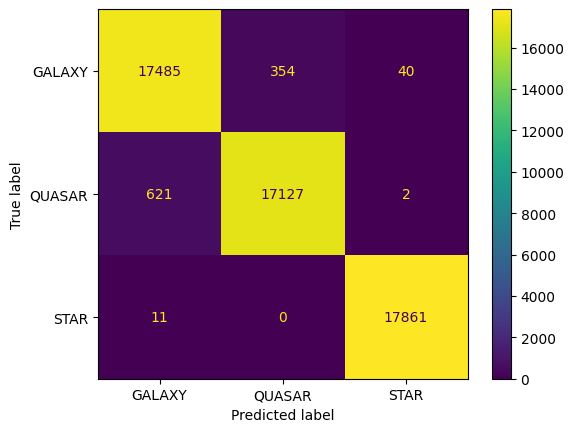

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)


ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])


cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_rfc = rfc.score(X_test, y_test)
print("Accuracy using Random Forest Classifier:", accuracy_rfc)

We will now proceed with the hyperparameter tuning process for RandomForests by employing RandomizedSearchCV.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)

In [34]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42)

In [35]:
print("Best Estimator:", random_search.best_estimator_)
print("Best Parameters:", random_search.best_params_)

Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=50, random_state=42)
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


In [36]:
best_rf_model = random_search.best_estimator_

0.981476981738659
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17879
           1       0.98      0.97      0.97     17750
           2       1.00      1.00      1.00     17872

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using optimized RFC: 0.981476981738659


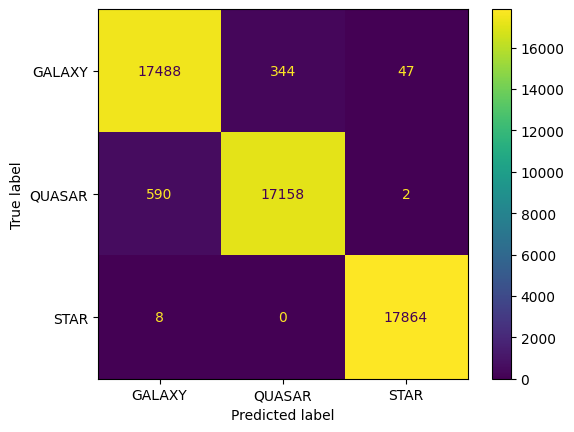

In [37]:
best_rf_model.get_params
best_rf_model.fit(X_train, y_train)
y_predict = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_model = best_rf_model.score(X_test, y_test)
print("Accuracy using optimized RFC:", accuracy_best_model)

In [38]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [10, 25, 50],
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)

In [39]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [30, 40, 50, 60],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [5],
                                        'n_estimators': [10, 25, 50]},
                   random_state=42)

In [40]:
print("Best Estimator:", random_search.best_estimator_)
print("Best Parameters:", random_search.best_params_)

Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=50, random_state=42)
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


0.981476981738659
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17879
           1       0.98      0.97      0.97     17750
           2       1.00      1.00      1.00     17872

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using optimized RFC: 0.981476981738659


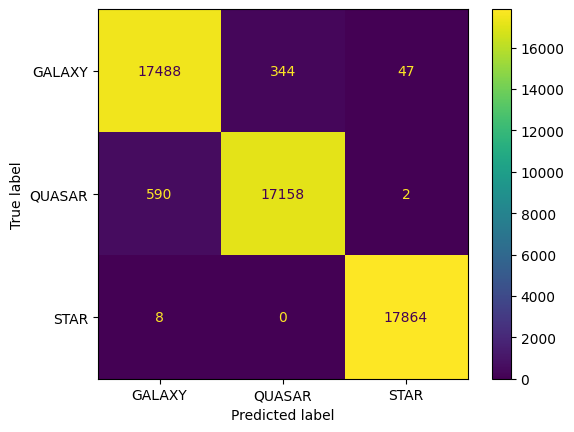

In [41]:
best_rf_model = random_search.best_estimator_
best_rf_model.get_params
best_rf_model.fit(X_train, y_train)
y_predict = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_model = best_rf_model.score(X_test, y_test)
print("Accuracy using optimized RFC:", accuracy_best_model)

We will now proceed with the hyperparameter tuning process for ExtraTreesClassifier by employing RandomizedSearchCV.

0.9817760415693164
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17879
           1       0.98      0.97      0.98     17750
           2       0.99      1.00      1.00     17872

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Extra Trees Classifier: 0.9817760415693164


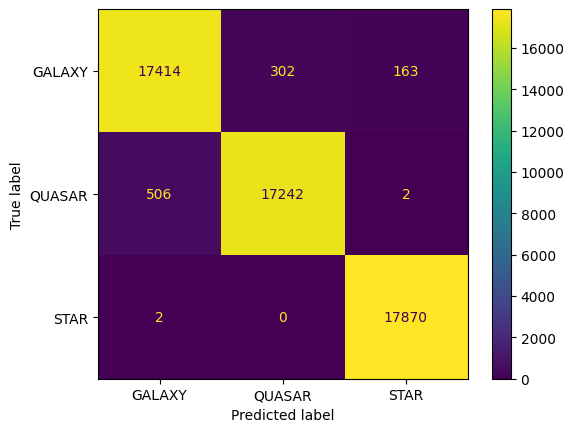

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

etc = ExtraTreesClassifier(random_state=42)
etc.fit(X_train, y_train)
y_predict = etc.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)


ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])


cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_etc = etc.score(X_test, y_test)
print("Accuracy using Extra Trees Classifier:", accuracy_etc)

In [43]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [10,50,100],
    'max_depth': [2,8,16,32,50],
    'max_features': ['auto','sqrt','log2'],    
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

random_search = RandomizedSearchCV(estimator=etc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 50, 100],
                                        'warm_start': [True, False]},
                   random_state=42)

In [44]:
print("Best Estimator:", random_search.best_estimator_)
print("Best Parameters:", random_search.best_params_)

Best Estimator: ExtraTreesClassifier(max_depth=32, n_estimators=50, random_state=42)
Best Parameters: {'warm_start': False, 'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}


0.9806919496831835
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17879
           1       0.98      0.97      0.98     17750
           2       0.99      1.00      1.00     17872

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Extra Trees Classifier: 0.9806919496831835


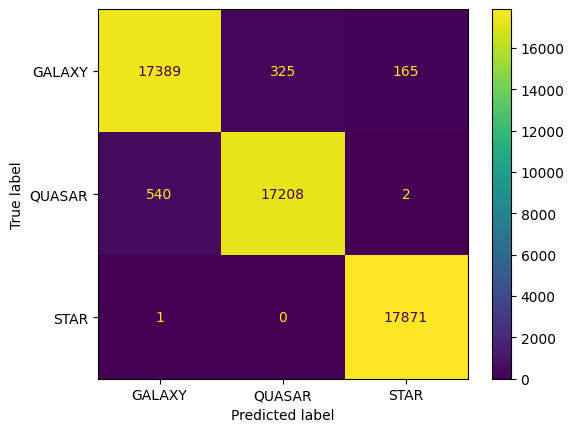

In [45]:
best_etc_model = random_search.best_estimator_
best_etc_model.get_params
best_etc_model.fit(X_train, y_train)
y_predict = best_etc_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_model = best_etc_model.score(X_test, y_test)
print("Accuracy using Extra Trees Classifier:", accuracy_best_model)


In the case of Extra Trees Classifier the primary model has given the best accuracy. 

We will now proceed with the hyperparameter tuning process for BaggingClassifier by employing RandomizedSearchCV.